<a href="https://colab.research.google.com/github/PranavPhanindra/Deep-Learning-PyTorch/blob/main/23357_MTCS_205P_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install torchviz

!pip install tensorboard


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=7674d0b2806406d4bb1aa2a7b3c3c7f85aec3bb692557010283f15123fde1d27
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter

# Data Loading and info about Data

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 17663612.20it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300633.55it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5555134.95it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5504021.67it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

#Defining labels for different classes of dataset

(-0.5, 27.5, 27.5, -0.5)

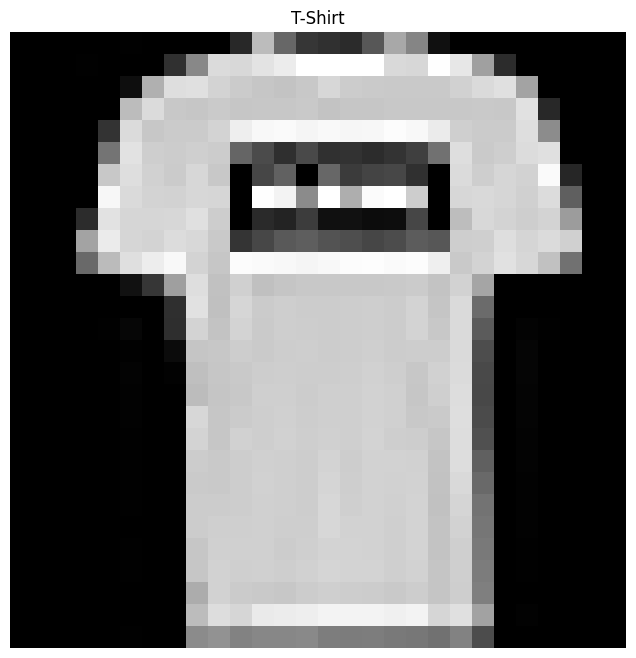

In [6]:
figure = plt.figure(figsize=(8, 8))
img,label = training_data[1]
img = img.reshape(28,28)
plt.imshow(img,cmap='gray')
plt.title(labels_map[label])
plt.axis("off")

In [7]:
img

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1608, 0.7373, 0.4039, 0.2118, 0.1882, 0.1686, 0.3412, 0.6588,
         0.5216, 0.0627, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.1922, 0.5333,
         0.8588, 0.8471, 0.8941, 0.9255, 1.0000, 1.0000, 1.0000, 1.0000, 0.8510,
         0.8431, 0.9961, 0.9059, 0.6275, 0.1765, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0549, 0.6902, 0.8706, 0.8784,
         0.8314, 0.7961, 0.7765, 0.7686, 0.7843, 0.8431, 0.8000, 0.7922, 0.7882,
         0.7882, 0.7882, 0.8196, 0.8549, 0.8784, 0.6431, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7373, 0.8588, 0.7843, 0.7765,
         0.7922, 0.7765, 0.7804, 0.7804, 0.7882, 0.7686, 0.7765, 0.7765, 0.7843,
         0.7843, 0.7843, 0.7843, 0.7882, 0.7843, 0.8824

# Creating Neural Network Class

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            #Layer 1 - 64 Nodes
            #Layer 2 - 128 Nodes
            #Relu Activation for each layer
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64 , 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
#Can also declare the layers as linear layer 1 etc..
#defining forward function that passes the data on each epoch
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Checking for the devices we have so that we can run the code either on GPU or on CPU

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [11]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


Here we see how the initialisations are done

In [12]:
"""for params in model.parameters() :
  print(params)"""
print("---------------------------------------------------------------------------------------")
for linParams in model.linear_relu_stack.named_parameters():
  print(linParams)
  print(linParams[1].size())
  print("---------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------
('0.weight', Parameter containing:
tensor([[-0.0162, -0.0219,  0.0166,  ..., -0.0118,  0.0351, -0.0091],
        [ 0.0057,  0.0050, -0.0163,  ...,  0.0079, -0.0060, -0.0284],
        [ 0.0030,  0.0154, -0.0297,  ...,  0.0140, -0.0353, -0.0254],
        ...,
        [ 0.0009, -0.0074,  0.0237,  ...,  0.0111, -0.0115,  0.0229],
        [-0.0171, -0.0111,  0.0035,  ..., -0.0116, -0.0251, -0.0315],
        [-0.0274, -0.0261,  0.0327,  ...,  0.0294,  0.0335, -0.0020]],
       requires_grad=True))
torch.Size([64, 784])
---------------------------------------------------------------------------------------
('0.bias', Parameter containing:
tensor([-0.0164, -0.0278,  0.0322,  0.0080,  0.0233, -0.0087,  0.0188, -0.0197,
         0.0179, -0.0340,  0.0283, -0.0029, -0.0040,  0.0304, -0.0178, -0.0162,
         0.0216, -0.0061, -0.0319, -0.0197,  0.0336, -0.0202,  0.0109,  0.0149,
         0.0195, -0.0090,  0.018

Hyper Parameters

## Train Loop

In [13]:
def train_loop(dataloader,model,lossFn,optimizer1) :

  size = len(dataloader.dataset)
  # Set the model to training mode
  model.train()

  for batch,(X,y) in enumerate(dataloader) :

    #Predictions and loss as we call forward and loss is calculated to be further used
    pred = model(X)
    #make_dot(pred, params=dict(model.named_parameters()))
    loss = lossFn(pred,y)

    #Backpropagation
    #Calculation of Gradient
    loss.backward()
    #This would update the weights and biases
    optimizer1.step()
    #This would zero down the gradients so that they arent added up in next step
    optimizer1.zero_grad()

    if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [14]:
def test_loop(dataloader, model, loss_fn):
    #Set model in evaluation mode
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [18]:
learningRate = 1e-1
batchSize  = 128
epochs = 100

In [19]:
train_dataloader = DataLoader(training_data, batch_size=batchSize)
test_dataloader = DataLoader(test_data, batch_size=batchSize)

In [20]:
#Combines LogSoftmax and NLLLoss - Negativce log likelihood
lossFn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model.parameters(),lr = learningRate)

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, lossFn, optimizer1)
    test_loop(test_dataloader, model, lossFn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.226266  [  128/60000]
loss: 0.225986  [12928/60000]
loss: 0.269020  [25728/60000]
loss: 0.279151  [38528/60000]
loss: 0.323790  [51328/60000]
Test Error: 
 Accuracy: 87.2%, Avg loss: 0.358314 

Epoch 2
-------------------------------
loss: 0.181390  [  128/60000]
loss: 0.223912  [12928/60000]
loss: 0.265356  [25728/60000]
loss: 0.271091  [38528/60000]
loss: 0.309324  [51328/60000]
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.355176 

Epoch 3
-------------------------------
loss: 0.172819  [  128/60000]
loss: 0.221062  [12928/60000]
loss: 0.263076  [25728/60000]
loss: 0.266214  [38528/60000]
loss: 0.301857  [51328/60000]
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.353491 

Epoch 4
-------------------------------
loss: 0.163916  [  128/60000]
loss: 0.213346  [12928/60000]
loss: 0.262011  [25728/60000]
loss: 0.261424  [38528/60000]
loss: 0.290393  [51328/60000]
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.351204 

Epoch 5
------------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
logsPath = "/content/drive/MyDrive/Colab Notebooks/MTCS-205/Assignments/"
writer = SummaryWriter(logsPath)

In [ ]:
randomVector = torch.randn(28*28,)
randomVector = randomVector.unsqueeze(0)
writer.add_graph(model,randomVector)

In [ ]:
!tensorboard --logdir "/content/drive/MyDrive/Colab Notebooks/MTCS-205/Assignments/"